In [1]:

%pylab inline
#%matplotlib notebook

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys,os
sys.path.append('..')
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam, OptParamArray
from backtester.swarms.ranking import SwarmRanker
from backtester.swarms.rebalancing import SwarmRebalance
from backtester.swarms.filters import SwarmFilter
from backtester.costs import CostsManagerEXOFixed
from backtester.exoinfo import EXOInfo
from backtester.swarms.rankingclasses import *
from backtester.swarms.swarm import Swarm

In [3]:
import cufflinks as cf
cf.go_offline()

import pandas as pd
import numpy as np
import scipy
import seaborn as sn

In [4]:
from scripts.settings import *
try:
    from scripts.settings_local import *
except:
    pass

from exobuilder.data.exostorage import EXOStorage

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)


exo_filter = '_ContFut'     # All 
#exo_filter = '_Bi_'  # ES only
#exo_filter = 'ES*Collar'  # ES Collars (incl Bearish, Bullish, BW and vanilla)

[print(exo) for exo in storage.exo_list(exo_filter)];

ES_ContFut
ZN_ContFut
ZW_ContFut
ZC_ContFut
LBS_ContFut
ZL_ContFut
ZS_ContFut
6J_ContFut
6A_ContFut
HO_ContFut
CC_ContFut
DC_ContFut
6C_ContFut
6E_ContFut
6B_ContFut
LE_ContFut
SB_ContFut
HE_ContFut
KC_ContFut
ZF_ContFut
ZB_ContFut
NQ_ContFut
N9L_ContFut
E4L_ContFut
B6L_ContFut
L3L_ContFut
V3L_ContFut
AL1_ContFut
R7L_ContFut
AW6_ContFut
CL_ContFut
XAB_ContFut
NG_ContFut
RB_ContFut
XAF_ContFut
XAY_ContFut
XAP_ContFut
XAE_ContFut
XAV_ContFut
XAI_ContFut
XAK_ContFut
XAU_ContFut
GC_ContFut
SI_ContFut
HG_ContFut
VX_ContFut


In [5]:
from sklearn import (pipeline, preprocessing, ensemble, neighbors, model_selection)
from scipy import signal, ndimage

class Strategy_DSP_LPBP_Combination(StrategyBase):
    name = 'Strategy_DSP_LPBP_Combination'


    def __init__(self, strategy_context):
        # Initialize parent class
        super().__init__(strategy_context)
   
    def calc_entryexit_rules(self, lp_order, lp_freq, bp_order, bp_startfreq, bp_stopfreq, bp_multiplier, rule_index):
        px_ser = self.data.exo
        
        b, a = signal.butter(lp_order, lp_freq, btype='lowpass')
    
        lpfilt = px_ser.copy()
        lpfilt.values[:] = signal.lfilter(b, a, lpfilt) 
        
        b, a = signal.butter(bp_order, [bp_startfreq, bp_stopfreq], btype='bandpass')
    
        bpfilt = px_ser.copy()
        bpfilt.values[:] = signal.lfilter(b, a, bpfilt) 
        
        lpbp = lpfilt - bpfilt*bp_multiplier
        
        if rule_index == 0: 
            entry_rule = CrossDown(lpbp, px_ser)
            exit_rule = CrossUp(lpbp, px_ser)

            return entry_rule, exit_rule
        
        elif rule_index == 1: 
            entry_rule = CrossUp(lpbp, px_ser)
            exit_rule = CrossDown(lpbp, px_ser)

            return entry_rule, exit_rule
        
        elif rule_index == 2: 
            entry_rule = lpbp > lpfilt
            exit_rule = lpbp < lpfilt

            return entry_rule, exit_rule

        elif rule_index == 3: 
            entry_rule = lpbp < lpfilt
            exit_rule = lpbp > lpfilt

            return entry_rule, exit_rule
            
    def calculate(self, params=None, save_info=False):
    #
    #
    #  Params is a tripple like (50, 10, 15), where:
    #   50 - slow MA period
    #   10 - fast MA period
    #   15 - median period
    #
    #  On every iteration of swarming algorithm, parameter set will be different.
    #  For more information look inside: /notebooks/tmp/Swarming engine research.ipynb
    #

        if params is None:
            # Return default parameters
            (direction, lp_order, lp_freq, bp_order, bp_startfreq, bp_stopfreq, bp_multiplier, rule_index) = self.default_opts()
        else:
            # Unpacking optimization params
            #  in order in self.opts definition
            (direction, lp_order, lp_freq, bp_order, bp_startfreq, bp_stopfreq, bp_multiplier, rule_index) = params

        # Defining EXO price
        px = self.data.exo
                
        entry_rule, exit_rule = self.calc_entryexit_rules(lp_order, lp_freq, bp_order, bp_startfreq, 
                                                          bp_stopfreq, bp_multiplier, rule_index)

        # Swarm_member_name must be *unique* for every swarm member
        # We use params values for uniqueness
        swarm_member_name = self.get_member_name(params)

        #
        # Calculation info
        #
        calc_info = None
        if save_info:
            calc_info = {'trailing_stop': trailing_stop}

        return swarm_member_name, entry_rule, exit_rule, calc_info

## Optunity params optimization

In [6]:
def make_walkforward_val_splits(exo_ser, step):
    wf_split_idx_l = []

    i = int(exo.size / 2)
    step = step

    while i < exo.size:
        wf_split_idx_l.append(exo.iloc[i: i+step].index)
        i += step
        
    return wf_split_idx_l



def modsharpe(pnl_ser):
    try:
        modsharpe = np.mean(pnl_ser) / np.std(pnl_ser)

    except ZeroDivisionError:
        modsharpe = np.nan
        
    return modsharpe

def max_dd(pnl_ser):
    return (pnl_ser.cumsum() - pnl_ser.cumsum().expanding().max()).min()

def recovery_factor(pnl_ser):
    max_dd = (pnl_ser.cumsum() - pnl_ser.cumsum().expanding().max()).min()
    return pnl_ser.cumsum().iloc[-1] / abs(max_dd)

def avg_pnl(pnl_ser):
    return pnl_ser.mean()

def netprofit(pnl_ser):
    return pnl_ser.cumsum().iloc[-1]

def profitfactor(pnl_ser):
    return pnl_ser[pnl_ser > 0].sum() / np.abs(pnl_ser[pnl_ser < 0].sum())

def winrate(pnl_ser):
    return len(pnl_ser[pnl_ser > 0]) / len(pnl_ser)

In [7]:
from backtester import matlab, backtester_fast
import optunity
import optunity.metrics

opt_df = pd.DataFrame(columns=['param1', 'param2', 'param3', 'param4', 'param5', 'param6', 'param7']) # placeholder df

direction = 1 # Set direction here : 1 or -1

def context(opt_df):
    STRATEGY_CONTEXT = {
        'strategy': { 
            'class': Strategy_DSP_LPBP_Combination,
            'exo_name': 'VX_ContFut',        # <---- Select and paste EXO name from cell above
            'exo_storage': storage,
            'direction': direction,
            'opt_params': [
                    OptParamArray('Direction', [direction]),
                    OptParamArray('LP order', opt_df.param1.drop_duplicates().values),
                    OptParamArray('LP freq', opt_df.param2.drop_duplicates().values),
                    OptParamArray('BP order', opt_df.param3.drop_duplicates().values),
                    OptParamArray('BP start freq', opt_df.param4.drop_duplicates().values),
                    OptParamArray('BP stop freq', opt_df.param5.drop_duplicates().values),
                    OptParamArray('BP multiplier', opt_df.param6.drop_duplicates().values),
                    OptParamArray('Rules index', opt_df.param7.drop_duplicates().values),
                ],
        },    
        'swarm': {
            'members_count': 1,
            'ranking_class':RankerHighestReturns(30), #RankerBestWithCorrel(window_size=-1, correl_threshold=0.7),#
            #note different ranker
            'rebalance_time_function': SwarmRebalance.every_friday,

        },
        'costs':{
            'manager': CostsManagerEXOFixed,
            'context': {
                'costs_options': 3.0,
                'costs_futures': 5.0,
            }
        }
    }
    return STRATEGY_CONTEXT

STRATEGY_CONTEXT = context(opt_df)

In [8]:
exostorage_ = STRATEGY_CONTEXT['strategy']['exo_storage']
exoname = STRATEGY_CONTEXT['strategy']['exo_name']

exo = exostorage_.load_series(exoname)[0]
strategy = STRATEGY_CONTEXT['strategy']['class'](STRATEGY_CONTEXT)

In [9]:
btester = backtester_fast

opt_target = 'netprofit' # choose optimization 
                         # target from - 'avg_pnl' 'profitfactor' 'netprofit'
                         #'recovery_factor' 'modsharpe' 'winrate'

        

def alpha_params_opt(param1, param2, param3, param4, param5, param6, param7, direction=direction, 
                     exo=exo[:int(exo.shape[0]/2)], opt_target=opt_target):
    # params
    direction = int(direction)
    
    param1 = int(param1)
    param2 = param2
    param3 = int(param3)
    param4 = param4
    param5 = param5
    param6 = int(param6)
    param7 = int(param7)
    
    _, entry_rule, exit_rule, _ = strategy.calculate(params=(direction, param1, param2, param3, param4, param5, param6, param7))
    
    entry_rule = entry_rule.iloc[: int(entry_rule.size/2)] # OPTIMIZE PARAMS ON THE HALF OF AVAILABLE DATA
    exit_rule = exit_rule.iloc[: int(exit_rule.size/2)]
    
    #
    #
    # Evaluation
    #
    #
    if opt_target == 'avg_pnl':
        opt_target = avg_pnl
        
    elif opt_target == 'profitfactor':
        opt_target = profitfactor
        
    elif opt_target == 'netprofit':
        opt_target = netprofit
        
    elif opt_target == 'recovery_factor':
        
        opt_target = recovery_factor
        
    elif opt_target == 'modsharpe':
        opt_target = modsharpe
        
    elif opt_target == 'winrate':
        opt_target = winrate   
    
    
    iis_pl, inposition = btester.backtest(exo, entry_rule.values, exit_rule.values, direction) # wf_splits[0][0] = 
                                                                                              # first day of out-of-sample data
     
    iis_metric = opt_target(iis_pl)

    return iis_metric



optimal_params, info, _ = optunity.maximize(alpha_params_opt, num_evals=900,
                                            param1=[1,3], param2=[0.1,0.91], 
                                            param3=[0,2], param4=[0,1], 
                                            param5=[0.15,1], param6=[-10,10], param7=[0,2], 
                                            solver_name='particle swarm')

In [10]:
opt_df = optunity.call_log2dataframe(info.call_log).dropna()
opt_df = opt_df.sort_values(by='value', ascending=False).groupby('value').last().sort_index(ascending=False)
opt_df
opt_df.param1 = opt_df.param1.astype(int)
opt_df.param3 = opt_df.param3.astype(int)
opt_df.param6 = opt_df.param6.astype(int)
opt_df.param7 = opt_df.param7.astype(int)
    
n_best_params = 5

opt_df = opt_df.iloc[: n_best_params]
opt_df.rename_axis(opt_target)

param1    param2  param3    param4    param5  param6  param7
netprofit                                                              
21610.0         2  0.657567       1  0.685781  0.529140      -1       0
19700.0         2  0.654521       1  0.692325  0.518863      -1       0
19070.0         2  0.663022       1  0.702232  0.505322      -1       0
18290.0         2  0.657569       1  0.687885  0.526649      -1       0
18080.0         2  0.663607       1  0.684150  0.532269      -1       0

In [11]:
# opt_df = optunity.call_log2dataframe(info.call_log).dropna()
# opt_df = opt_df.sort_values(by='value', ascending=False).groupby('value').last().sort_index(ascending=False).astype(int)

# n_best_params = 5

# opt_df = opt_df.iloc[: n_best_params]
# opt_df.rename_axis(opt_target)
opt_df

param1    param2  param3    param4    param5  param6  param7
value                                                                
21610.0       2  0.657567       1  0.685781  0.529140      -1       0
19700.0       2  0.654521       1  0.692325  0.518863      -1       0
19070.0       2  0.663022       1  0.702232  0.505322      -1       0
18290.0       2  0.657569       1  0.687885  0.526649      -1       0
18080.0       2  0.663607       1  0.684150  0.532269      -1       0

In [12]:
# np.set_printoptions(precision=4)
print('parameter1 - ', list(opt_df.param1.unique()))
print('parameter2 - ', [float("{0:0.2f}".format(i)) for i in opt_df.param2.unique()])
print('parameter3 - ', list(opt_df.param3.unique()))
print('parameter4 - ', [float("{0:0.3f}".format(i)) for i in opt_df.param4.unique()])
print('parameter5 - ', [float("{0:0.3f}".format(i)) for i in opt_df.param5.unique()])
print('parameter6 - ', list(opt_df.param6.unique()))
print('parameter7 - ', list(opt_df.param7.unique()))

parameter1 -  [2]
parameter2 -  [0.66, 0.65, 0.66, 0.66, 0.66]
parameter3 -  [1]
parameter4 -  [0.686, 0.692, 0.702, 0.688, 0.684]
parameter5 -  [0.529, 0.519, 0.505, 0.527, 0.532]
parameter6 -  [-1]
parameter7 -  [0]


### Update strategy opt. params

In [13]:
STRATEGY_CONTEXT = context(opt_df)

# Backtest class based strategy

In [14]:
smgr = Swarm(STRATEGY_CONTEXT)
smgr.run_swarm()
smgr.pick()

In [15]:
#from backtester.reports.alpha_sanity_checks import AlphaSanityChecker
#asc = AlphaSanityChecker(smgr)
#asc.run()
smgr.raw_swarm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1640 entries, 2011-06-01 to 2019-02-28
Columns: 125 entries, (1, 2, 0.6545214399901429, 1, 0.6841500274772161, 0.5053216610662598, -1, 0) to (1, 2, 0.6636074218749994, 1, 0.7022316403305227, 0.5322691324471172, -1, 0)
dtypes: float64(125)
memory usage: 1.6 MB


In [16]:
last_opt_date = smgr.strategy.data.exo.iloc[:int(smgr.strategy.data.exo.shape[0]/2)].index[-1]

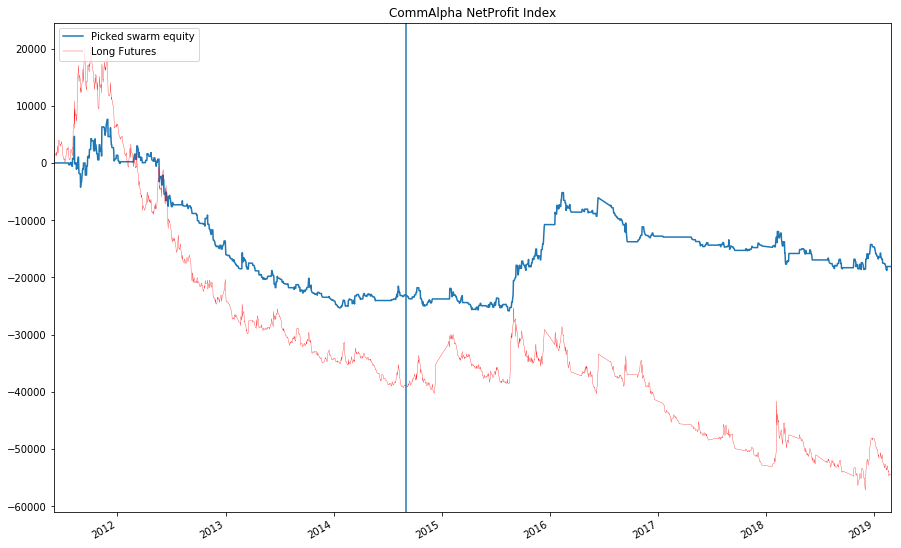

In [17]:
figsize(15,10)
smgr.picked_equity.tail(3100).plot(label='Picked swarm equity',title= "CommAlpha NetProfit Index");
# smgr.raw_equity.plot(label='Average swarm equity');
(smgr.strategy.data.exo*1).plot(label='Long Futures',linewidth=0.3, color='red')
axvline(last_opt_date)
legend(loc=2);

In [ ]:
import bt
data = bt.merge(smgr.picked_equity,smgr.picked_delta)
data.tail()
data_equity = bt.merge(smgr.picked_equity)
data_equity.to_csv('Strat_ML_Sar_VX_long_6.csv')

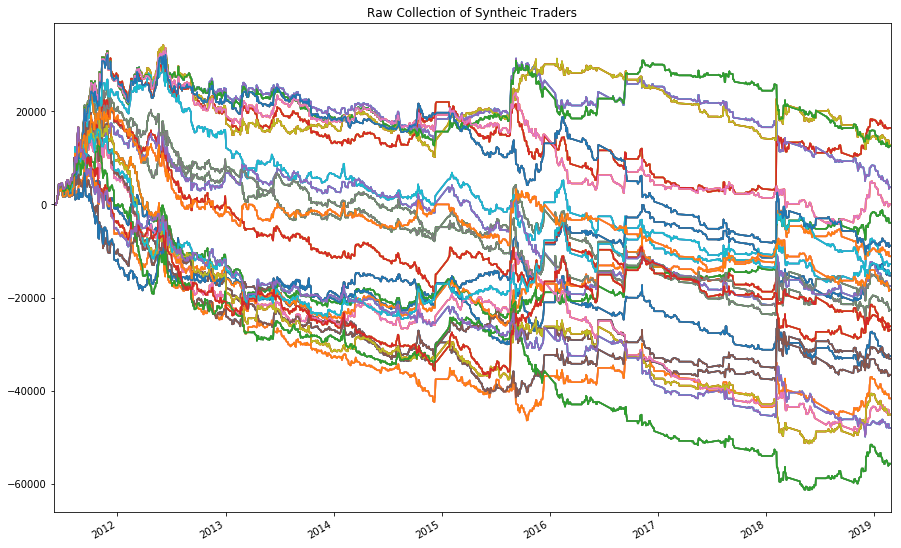

In [161]:
smgr.raw_swarm.plot(legend=False,title= "Raw Collection of Syntheic Traders");

In [91]:
df = smgr.raw_swarm.copy()

for col in df:
    df[col] = df[col] + 100000
    df[col] = df[col] / df[col].shift(-5) - 1
#     df[col] = np.log(1+df[col])
    df[col] = df[col].replace([np.inf, -np.inf], np.nan).fillna(0)
    
cols = list(df)

In [92]:
df_exo = pd.DataFrame(smgr.strategy.data.exo)
df_exo['exo'] = df_exo['exo'] + 100000
df_exo['exo'] = df_exo['exo'] / df_exo['exo'].shift(-5) - 1
# #     df[col] = np.log(1+df[col])
df_exo['exo'] = df_exo['exo'].replace([np.inf, -np.inf], np.nan).fillna(0)
# df_exo['test'] = df[cols[0]]

In [93]:
# smgr.raw_swarm[cols[1]].plot()
# smgr.strategy.data.exo.plot()
# plt.show()

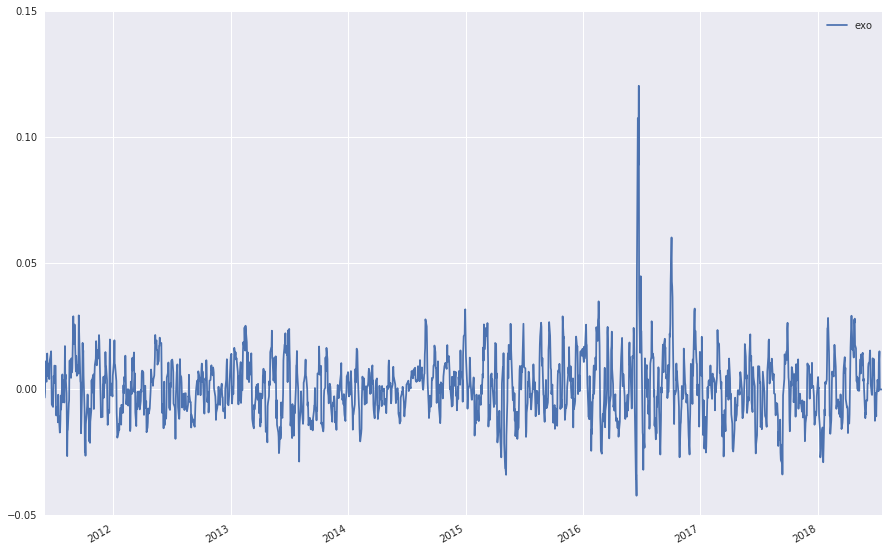

In [94]:
# df[cols[0]].plot()
df_exo.plot()

In [100]:
rtn = ((smgr.raw_swarm[cols[1]].iloc[-1]/smgr.raw_swarm[cols[1]].iloc[-1000])**(1/(1000/252)) - 1)
risk = (std(df[cols[1]].iloc[-1000:]))*(sqrt(252))
print(rtn/risk)

nan


In [101]:
rtn

nan

In [102]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [103]:
result_df = pd.DataFrame()

In [104]:
result_list = []
X = df_exo['exo'].values
for column in cols:
#     column = 10
    y = df[column].values


#     plt.scatter(X, y)
#     plt.show()

    # X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), y, test_size=0.3,random_state=21)

    reg_all = linear_model.LinearRegression() 

    reg_all.fit(X.reshape(-1, 1), y) 

    # y_pred = reg_all.predict(X_test) 

    # b = reg_all.intercept_
#     print(reg_all.coef_)
#     print(reg_all.intercept_)
    rtn = ((smgr.raw_swarm[column].iloc[-1]/smgr.raw_swarm[column].iloc[-1000])**(1/(1000/252)) - 1)
    risk = (std(df[column].iloc[-1000:]))*(sqrt(252))
    sharpe = rtn/risk
    if math.isnan(sharpe):
        sharpe = 0
        
    result_list.append([reg_all.coef_[0],reg_all.intercept_,sharpe])
#     print(sharpe)
#     break

In [105]:
#result_list

In [119]:
from sklearn.cluster import KMeans 
number_of_clusters = 9
model = KMeans(n_clusters=number_of_clusters)
model.fit(result_list)
KMeans(algorithm='auto') 
labels = model.predict(result_list) 
print(labels)

[5 5 8 8 5 5 2 7 7 6 5 1 3 3 6 6 6 5 5 4 0 0 5 5 5 5 5 8 8 5 5 2 7 7 6 5 1
 3 3 6 6 6 5 5 4 0 0 5 5 5 5 5 8 8 5 5 2 7 7 6 5 1 3 3 6 6 6 5 5 4 0 0 5 5
 5 5 5 8 8 5 5 2 7 7 6 5 1 3 3 6 6 6 5 5 4 0 0 5 5 5 5 5 8 8 5 5 2 7 7 6 5
 1 3 3 6 6 6 5 5 4 0 0 5 5 5]


In [133]:
# result_list[result_list == 5]
# smgr.raw_swarm[cols[1]]
returns = []
stds = []
cluster_label = []
plot_optimal = 8  #2




'Cluster group 8'

parameter1 -  [1]
parameter2 -  [0.37, 0.377, 0.378, 0.381, 0.386]
parameter3 -  [4]
parameter4 -  [0.322]
parameter5 -  [0.313, 0.313]
parameter6 -  [1]
parameter7 -  [1]


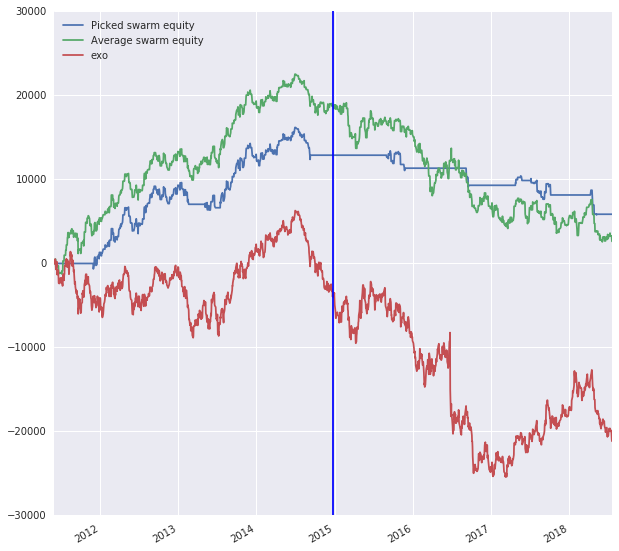

In [134]:
for cluster in range(number_of_clusters):
    itemindex = numpy.where(labels==cluster)
    # cols[0]
    itemindex_list = list(itemindex[0])
    # cols[x[0]]

    # x = pd.DataFrame(columns=['param1','param2','param3','param4','param5','param6','param7'])
    param_list = []
    for idx in itemindex_list:
    #     smgr.raw_swarm[cols[idx]].plot()
        xl = cols[idx].replace(")","").split(",")
    #     print(xl)
        for i,v in enumerate(xl):
            if i == 1:
                param1 = int(v)
            elif i == 2:
                param2 = float(v)
            elif i == 3:
                param3 = int(v)
            elif i == 4:
                param4 = float(v)
            elif i == 5:
                param5 = float(v)
            elif i == 6:
                param6 = int(v)
            elif i == 7:
                param7 = int(v)
        param_list.append([param1,param2,param3,param4,param5,param6,param7])

    param_df=pd.DataFrame(param_list,columns=['param1','param2','param3','param4','param5','param6','param7'])
    
#     print('parameter1 - ', list(param_df.param1.unique()))
#     print('parameter2 - ', [float("{0:0.3f}".format(i)) for i in param_df.param2.unique()])
#     print('parameter3 - ', list(param_df.param3.unique()))
#     print('parameter4 - ', [float("{0:0.3f}".format(i)) for i in param_df.param4.unique()])
#     print('parameter5 - ', [float("{0:0.3f}".format(i)) for i in param_df.param5.unique()])
#     print('parameter6 - ', list(param_df.param6.unique()))
#     print('parameter7 - ', list(param_df.param7.unique()))

    param_dict = {
        'param1':list(param_df.param1.unique()),
        'param2':[float("{0:0.3f}".format(i)) for i in param_df.param2.unique()],
        'param3':list(param_df.param3.unique()),
        'param4':[float("{0:0.3f}".format(i)) for i in param_df.param4.unique()],
        'param5':[float("{0:0.3f}".format(i)) for i in param_df.param5.unique()],
        'param6':list(param_df.param6.unique()),
        'param7':list(param_df.param7.unique())    
    }
    
    STRATEGY_CONTEXT = {
    'strategy': { 
        'class': Strategy_DSP_LPBP_Combination,
        'exo_name': '6B_ContFut',        # <---- Select and paste EXO name from cell above
        'exo_storage': storage,          
        'opt_params': [
                        OptParamArray('Direction', [1]),
                        OptParamArray('LP order',param_dict['param1']),
                        OptParamArray('LP freq',param_dict['param2']), # 0 > f < 1
                        OptParamArray('BP order',param_dict['param3']),
                        OptParamArray('BP start freq',param_dict['param4']),
                        OptParamArray('BP stop freq',  param_dict['param5']),
                        OptParamArray('BP multiplier',param_dict['param6']),
                        OptParamArray('Rule index',   param_dict['param7']),
                        
            ],
    },
    'swarm': {
        'members_count': 1,
        'ranking_class': RankerHighestReturns(120),#RankerBestWithCorrel(window_size=-1, correl_threshold=-0.8),
        'rebalance_time_function': SwarmRebalance.every_friday,

    },
    'costs':{
        'manager': CostsManagerEXOFixed,
        'context': {
            'costs_options': 3.0,
            'costs_futures': 3.0,
        }
    }
    }
    
    smgr = Swarm(STRATEGY_CONTEXT)
    smgr.run_swarm()
    smgr.pick()
    
    if plot_optimal and plot_optimal == cluster:
        display('Cluster group {}'.format(plot_optimal))        
        print('parameter1 - ', param_dict['param1'])
        print('parameter2 - ', param_dict['param2'])
        print('parameter3 - ', param_dict['param3'])
        print('parameter4 - ', param_dict['param4'])
        print('parameter5 - ', param_dict['param5'])
        print('parameter6 - ', param_dict['param6'])
        print('parameter7 - ', param_dict['param7'])
        
        figsize(10,10)
        smgr.picked_equity.tail(2220).plot(label='Picked swarm equity');
        smgr.raw_equity.plot(label='Average swarm equity');
        (smgr.strategy.data.exo*1).plot()
        axvline(last_opt_date)
        legend(loc=2);
        plt.show()
    
    equity = smgr.picked_equity + 100000
    
    rtn = ((equity.iloc[-1]/equity.iloc[0])**(1/(len(equity)/252)) - 1)
    risk = (std(equity/equity.shift(1)))*(sqrt(252))
    
    returns.append(rtn)
    stds.append(risk)
    cluster_label.append(cluster)
    

In [135]:
smgr = Swarm(STRATEGY_CONTEXT)
smgr.run_swarm()
smgr.pick()

In [136]:
# smgr.raw_swarm.plot(legend=False);

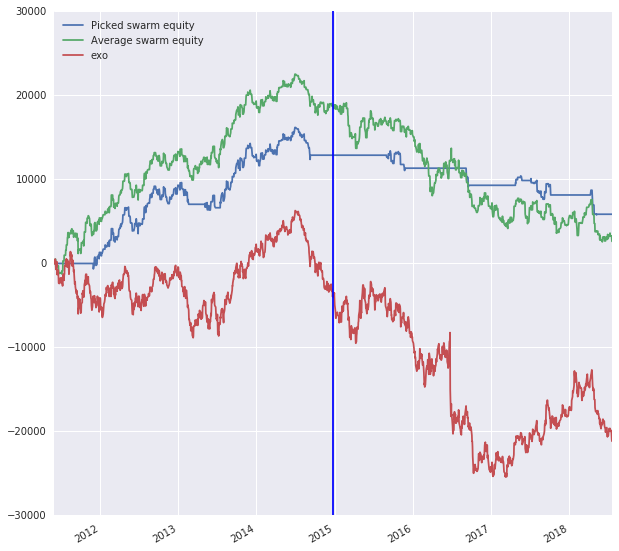

In [137]:
figsize(10,10)
smgr.picked_equity.tail(2220).plot(label='Picked swarm equity');
smgr.raw_equity.plot(label='Average swarm equity');
(smgr.strategy.data.exo*1).plot()
axvline(last_opt_date)
legend(loc=2);

In [132]:
returns

[0.029269312589782048,
 -0.00028497955308537382,
 -0.00028497955308537382,
 0.0080490473607999213,
 0.001260420984032784,
 0.011079015023388372,
 0.012210422470131155,
 0.0080490473607999213,
 0.0080490473607999213]

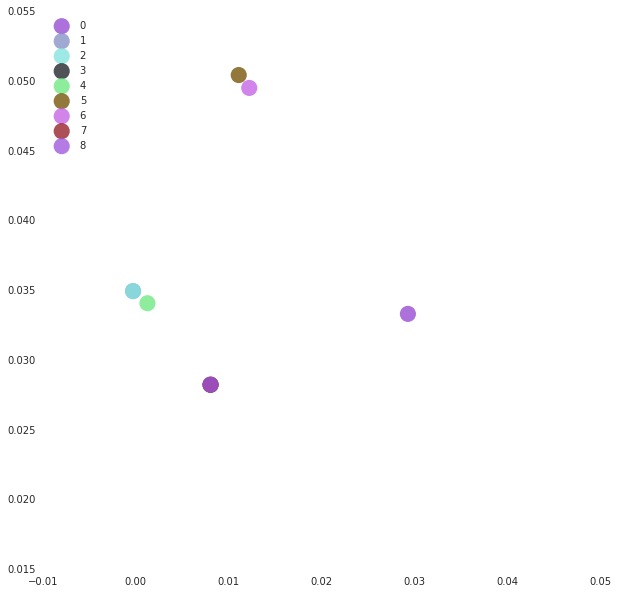

In [126]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, axisbg="1.0")

for r, s, cl in zip(returns, stds, cluster_label):
    x, y = r, s
    ax.scatter(x, y, alpha=4.8, c=numpy.random.rand(3,1), edgecolors='none', s=260, label=cl)


      
    

#plt.scatter(returns,stds,label=cluster_label)
plt.legend(loc=2)

plt.show()

In [45]:
print(zip(returns, stds, cluster_label))

In [ ]:
smgr.picked_swarm.plot()

###### 

# Swarm exposure

In [ ]:
smgr.picked_exposure.sum(axis=1).rolling(10).mean().plot()

# Swarm statistics

#### Non-picked swarm stats

In [ ]:
smgr.picked_stats

## Exo information

In [ ]:
smgr.strategy.exoinfo.exo_info

In [ ]:
smgr.strategy.exoinfo.data.exo.plot()

### Global filter information (obsolete)


## Costs information (per 1-exo unit)

In [ ]:
figsize(10,5)
smgr.strategy.costs.plot()

## Margin graphs

### EXO Margin (per 1 EXO unit)

In [ ]:
smgr.strategy.exoinfo.margin().plot()

# Saving results

In [ ]:
smgr.save('./swarms/')